## Deep Neural Network

Imports

In [61]:
import os
import keras
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit

Load in the data

In [62]:
data_movies = pd.read_csv("data/movies.csv")
data_ratings = pd.read_csv("data/ratings.csv")

Transform the data

In [63]:
genres = data_movies['genres'].str.get_dummies('|')

merged_dataset = pd.merge(data_movies,data_ratings, how='inner', on='movieId')

refined_dataset = merged_dataset.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})

# Encode the userid and movie title to prepare for DNN
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['userId'].to_numpy())
item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['title'].to_numpy())
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)

joblib.dump(user_enc, 'data/user_enc.pkl')
joblib.dump(item_enc, 'data/item_enc.pkl')

['data/item_enc.pkl']

In [64]:
n_users = refined_dataset['user'].nunique()
n_movies = refined_dataset['movie'].nunique()
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])

Define X and Y data

In [65]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values

n_factors = 100


splitter = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=50)
for train_idx, test_idx in splitter.split(X, y, groups=refined_dataset['userId']):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


X_train_combined = [X_train[:,0], X_train[:,1]] #type: ignore
X_test_combined = [X_test[:,0], X_test[:,1]] #type: ignore

### Define the layers and the model

In [66]:
user = keras.layers.Input(shape = (1,))

# Embedding layer for n_factors of users
u = keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = keras.regularizers.l2(1e-6))(user)
u = keras.layers.Reshape((n_factors,))(u)

# Input layer for the movies
movie = keras.layers.Input(shape = (1,))

# Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer= keras.regularizers.l2(1e-6))(movie)
m = keras.layers.Reshape((n_factors,))(m)

# stacking up both user and movie embeddings
x = keras.layers.Concatenate()([u,m])
x = keras.layers.Dropout(0.05)(x)

# Adding a Dense layer to the architecture
x = keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Dropout(0.05)(x)

x = keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Dropout(0.05)(x)

# Output layer 
x = keras.layers.Dense(1)(x)
x = keras.layers.Activation(activation='linear')(x)

# Define the model
model = keras.models.Model(inputs=[user,movie], outputs=x)

# Compiling the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(model.summary())


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_16        │ (None, 1, 100)    │     61,000 │ input_layer_20[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (None, 1, 100)    │    971,900 │ input_layer_21[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_16          │ (None, 100)       │          0 │ embedding_16[0][… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_17          │ (None, 100)       │          0 │ embedding_17[0][… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 200)       │          0 │ reshape_16[0][0], │
│ (Concatenate)       │                   │            │ reshape_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 200)       │          0 │ concatenate_8[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 32)        │      6,432 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 32)        │          0 │ dense_24[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 32)        │          0 │ activation_24[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 16)        │        528 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 16)        │          0 │ dense_25[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 16)        │          0 │ activation_25[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 1)         │         17 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 1)         │          0 │ dense_26[0][0]    │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,039,877 (3.97 MB)

 Trainable params: 1,039,877 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

None


In [67]:

reduce_lr = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history = model.fit(x = X_train_combined,
                    y = y_train,
                    batch_size=128,
                    epochs=30,
                    validation_data=(X_test_combined, y_test),
                    shuffle=True,
                    callbacks=[reduce_lr])

Epoch 1/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 3.4552 - mae: 1.3912 - val_loss: 2.4450 - val_mae: 1.3769
Epoch 2/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.8117 - mae: 0.7008 - val_loss: 1.5263 - val_mae: 1.0419
Epoch 3/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.7476 - mae: 0.6679 - val_loss: 1.2948 - val_mae: 0.9438
Epoch 4/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.6936 - mae: 0.6398 - val_loss: 1.2127 - val_mae: 0.9054
Epoch 5/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.6480 - mae: 0.6165 - val_loss: 1.1499 - val_mae: 0.8734
Epoch 6/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.6096 - mae: 0.5960 - val_loss: 1.2157 - val_mae: 0.9019
Epoch 7/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.5692 - mae: 0.5747 - val_loss: 1.1914 - val_mae: 0.8925
Epoch 8/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5377 - mae: 0.5582 - val_loss: 1.1974 - val_mae: 0.8919
Epoch 8: early stopping


Save the model so we don't have to train the model each time

In [68]:
model.save("data/movie_recommendation_model.keras")

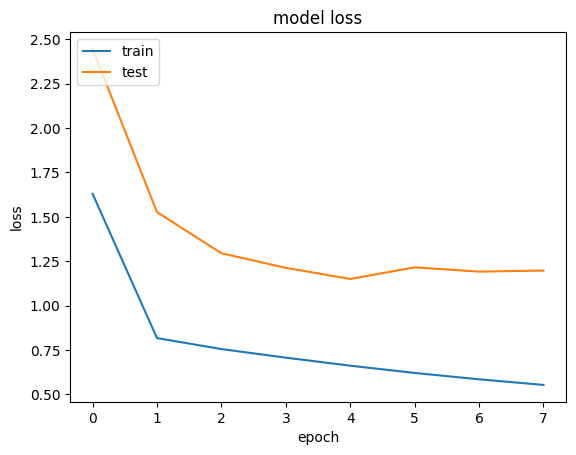

In [69]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()